In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

In [13]:
data1=pd.read_excel(r"../SAMSUNG/Office Sales.xlsx")
data2=pd.read_excel(r"../SAMSUNG/Superstore.xls")

In [6]:
data.columns

Index(['SalesOrderNumber', 'OrderDate', 'CategoryName', 'SubcategoryName',
       'UnitPrice', 'OrderQuantity', 'Discount %', 'OrderPriority'],
      dtype='object')

In [14]:
merged_df = pd.concat([data1, data2], ignore_index=True)

In [15]:
merged_df.to_excel('결과.xlsx', index=False)

In [25]:
data=pd.read_excel(r"../SAMSUNG/결과1.xlsx")
data

,SalesOrderNumber,OrderDate,CategoryName,SubcategoryName,UnitPrice,OrderQuantity,Discount %
0,IN-2017-47883,2017-01-01,Furniture,Furnishings,25.260,5,0.5
1,IZ-2017-4680,2017-01-03,Furniture,Chairs,166.710,4,0.6
2,ID-2017-80230,2017-01-03,Furniture,Chairs,57.390,2,0.2
3,ID-2017-80230,2017-01-03,Furniture,Chairs,132.870,2,0.0
4,ES-2017-4869686,2017-01-03,Furniture,Bookcases,122.070,7,0.6
...,...,...,...,...,...,...,...
18567,CA-2014-110422,2014-01-21,Furniture,Furnishings,25.248,3,0.2
18568,CA-2017-121258,2017-02-26,Furniture,Furnishings,91.960,2,0.0
18569,CA-2017-121258,2017-02-26,Technology,Phones,258.576,2,0.2
18570,CA-2017-121258,2017-02-26,Office Supplies,Paper,29.600,4,0.0


In [27]:
furniture=data.loc[data['CategoryName'] == 'Furniture']
office=data.loc[data['CategoryName'] == 'Office Supplies']

In [28]:
furniture.head()

,SalesOrderNumber,OrderDate,CategoryName,SubcategoryName,UnitPrice,OrderQuantity,Discount %
0,IN-2017-47883,2017-01-01,Furniture,Furnishings,25.26,5,0.5
1,IZ-2017-4680,2017-01-03,Furniture,Chairs,166.71,4,0.6
2,ID-2017-80230,2017-01-03,Furniture,Chairs,57.39,2,0.2
3,ID-2017-80230,2017-01-03,Furniture,Chairs,132.87,2,0.0
4,ES-2017-4869686,2017-01-03,Furniture,Bookcases,122.07,7,0.6


In [29]:
furniture= furniture.groupby('OrderDate')['OrderQuantity'].sum().reset_index()

In [30]:
furniture = furniture.set_index('OrderDate')

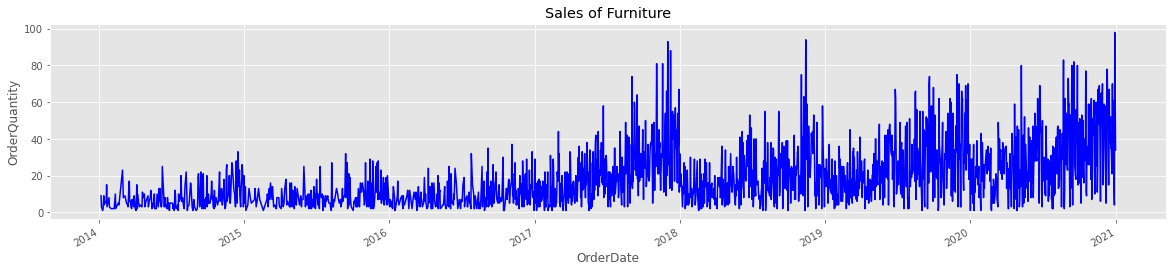

In [31]:
ax= furniture['OrderQuantity'].plot(color='blue',figsize=(20,4))
ax.set_xlabel("OrderDate")
ax.set_ylabel('OrderQuantity')
ax.set_title("Sales of Furniture")
plt.show()

In [32]:
df = furniture['OrderQuantity'].resample('MS').mean()

In [33]:
df.head(n=5)

OrderDate
2014-01-01    5.384615
2014-02-01    4.600000
2014-03-01    7.705882
2014-04-01    5.785714
2014-05-01    6.062500
Freq: MS, Name: OrderQuantity, dtype: float64

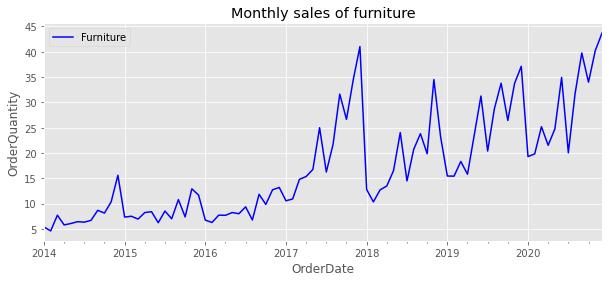

In [35]:
df.plot(figsize=(10, 4),color='blue',label = 'Furniture')

#avg_technology_sales.plot(figsize=(10, 4),color='red',label = 'Technology')

#avg_office_sales.plot(figsize=(10, 4),color='green',label = 'Office Supplies')
plt.xlabel("OrderDate")
plt.ylabel('OrderQuantity')
plt.title("Monthly sales of furniture")
plt.legend()
plt.show()

In [36]:
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])

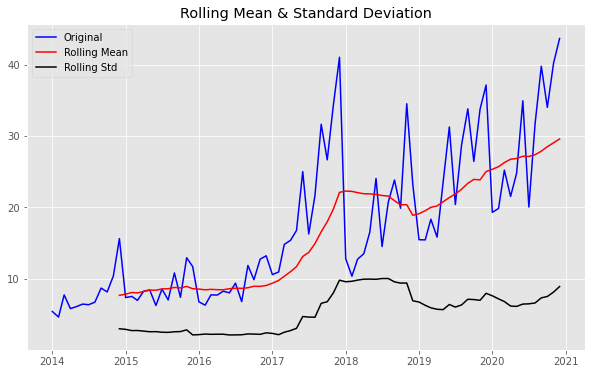

Results of Dickey-Fuller Test:
p-value= 0.9564104001365421


In [37]:
test_stationarity(df)

In [38]:
X = df
train_size = int(len(X) * 0.75)
trainset, testset= X[0:train_size], X[train_size:]

In [39]:
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

In [59]:
from statsmodels.tsa.arima_model import ARMA

model_arma = ARMA(trainset, order=(1, 1))
model_arma_fit = model_arma.fit(disp=False)
arma_predict = model_arma_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2020-12-31'),
                                       dynamic=False)

C:\Users\SAMSUNG\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


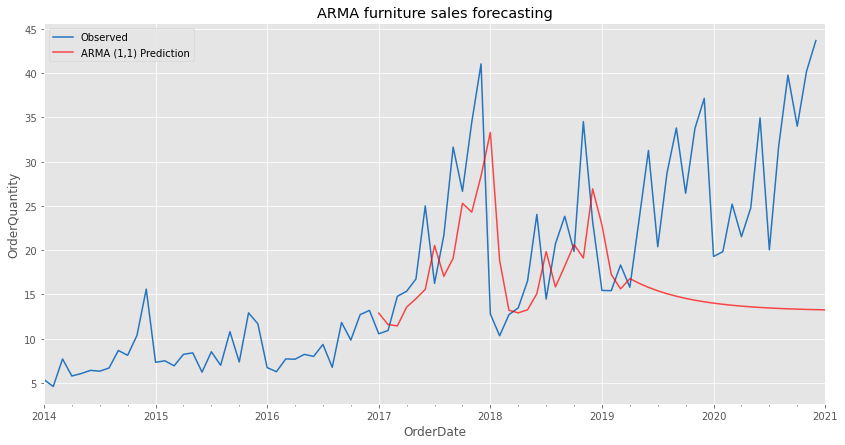

In [60]:
# One step ahead forecast
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arma_predict.plot(ax=ax, label='ARMA (1,1) Prediction', alpha= 0.7, color='red') 
plt.title('ARMA furniture sales forecasting')
plt.xlabel('OrderDate')
plt.ylabel('OrderQuantity')
plt.legend()
plt.show() #ARMA

In [61]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate the combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [62]:
p_values = [0, 1, 2, 4,6]
d_values = range(0, 2)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=242.881
ARIMA(0, 0, 1) MSE=117.631
ARIMA(0, 1, 0) MSE=68.849
ARIMA(0, 1, 1) MSE=54.003
ARIMA(1, 0, 0) MSE=74.466
ARIMA(1, 0, 1) MSE=62.857
ARIMA(1, 1, 0) MSE=60.844
ARIMA(1, 1, 1) MSE=51.046
ARIMA(2, 0, 0) MSE=69.306
ARIMA(2, 1, 0) MSE=46.555
ARIMA(2, 1, 1) MSE=41.053
ARIMA(4, 0, 0) MSE=47.561
ARIMA(4, 0, 1) MSE=46.975
ARIMA(4, 1, 0) MSE=40.278
ARIMA(4, 1, 1) MSE=32.217
ARIMA(6, 0, 0) MSE=38.355
ARIMA(6, 0, 1) MSE=37.390
ARIMA(6, 1, 0) MSE=31.394
ARIMA(6, 1, 1) MSE=31.726
Best ARIMA(6, 1, 0) MSE=31.394


In [64]:
from statsmodels.tsa.arima_model import ARIMA
model_arima = ARIMA(trainset, order = (6,0,0))
model_arima_fit = model_arima.fit(disp=False)
arima_predict = model_arima_fit.predict(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2020-12-31')
                                           ,dynamic=False)

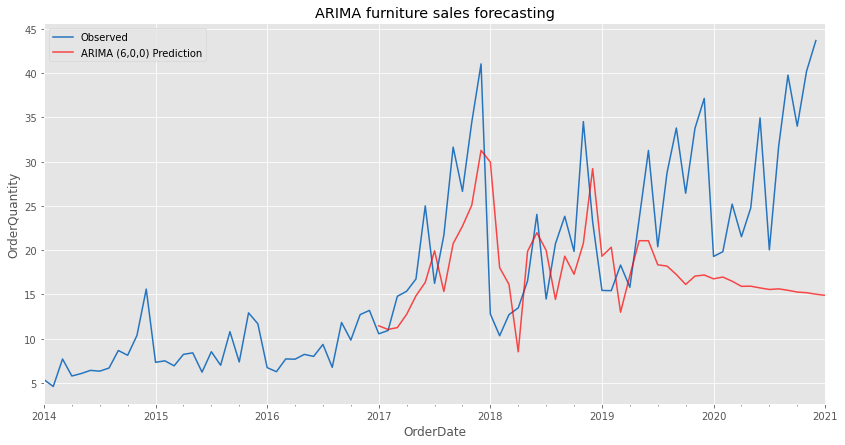

In [65]:
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
arima_predict.plot(ax=ax, label='ARIMA (6,0,0) Prediction', alpha= 0.7, color='red') 
plt.title('ARIMA furniture sales forecasting')
plt.xlabel('OrderDate')
plt.ylabel('OrderQuantity')
plt.legend()
plt.show() #ARIMA

In [66]:
#fitting model
sarima_model_1 = sm.tsa.statespace.SARIMAX(trainset,
                                order=(0, 0, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit_1 = sarima_model_1.fit()
print(sarima_fit_1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2617      0.228     -1.148      0.251      -0.708       0.185
sigma2        77.7135     11.865      6.550      0.000      54.459     100.968


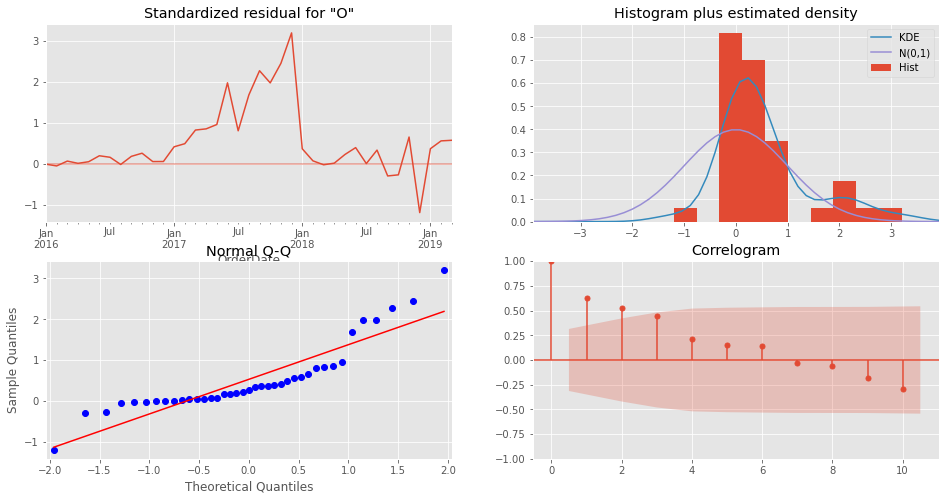

In [67]:
sarima_fit_1.plot_diagnostics(figsize=(16, 8))
plt.show()

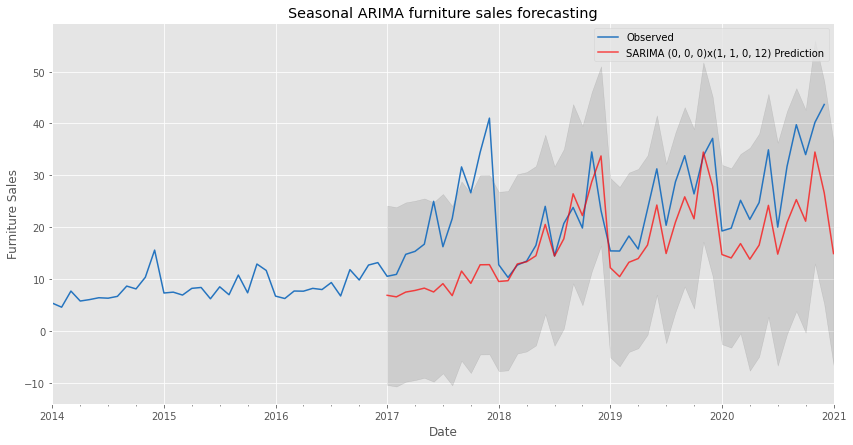

In [68]:
# One step ahead forecast
sarima_predict_1 = sarima_fit_1.get_prediction(start=pd.to_datetime('2017-01-01'), end=pd.to_datetime('2020-12-31')
                                           ,dynamic=False)
sarima_predict_conf_1 = sarima_predict_1.conf_int()
#observed plot
ax = df.plot(label='Observed',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7
sarima_predict_1.predicted_mean.plot(ax=ax, label='SARIMA (0, 0, 0)x(1, 1, 0, 12) Prediction', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf_1.index,
                #lower sales
                sarima_predict_conf_1.iloc[:, 0],
                #upper sales
                sarima_predict_conf_1.iloc[:, 1], color='k', alpha=0.1)
plt.title('Seasonal ARIMA furniture sales forecasting')
plt.xlabel('Date')
plt.ylabel('Furniture Sales')
plt.legend()
plt.show()